### 말뭉치 전처리

- 정규표현식: re 모듈
    - re.split('(\W+)?', text) 라고 호출하면 단어 단위로 분할 가능

In [4]:
text = "You say goodbye and I say hello."

In [5]:
text = text.lower()
text = text.replace('.', ' .') # 정규표현식 이용하는 게 더 범용적인 방법
text

'you say goodbye and i say hello .'

In [6]:
words = text.split(' ')
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [7]:
# 단어에 ID 부여하고 ID의 리스트로 이용할 수 있도록 처리
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

In [8]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [9]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [10]:
# '단어 목록'을 '단어 ID 목록'으로 변경하기
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [11]:
# 한 번에
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    
    word_to_id = {}
    id_to_word = {}

    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

### 동시발생 행렬

In [14]:
import sys
sys.path.append('..')
import numpy as np
# from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [15]:
# 동시발생 행렬
C = np.array([
    [0, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 1, 1, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 1, 0, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1, 0],
], dtype=np.int32)

In [16]:
print(C[0]) # ID가 0인 단어의 벡터 표현

[0 1 0 0 0 0 0]


In [17]:
print(C[4]) # ID가 4인 단어의 벡터 표현

[0 1 0 1 0 0 0]


In [18]:
print(C[word_to_id['goodbye']]) # 'goodbye'의 벡터 표현

[0 1 0 1 0 0 0]


In [23]:
# 말뭉치로부터 동시발생 행렬을 만들어주는 함수
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
                
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
                
    return co_matrix

### 코사인 유사도

In [21]:
def cos_similarity(x, y, eps=1e-8): # eps: 제로 벡터로 인한 divide by zero 에러 발생 방지
    nx = x / np.sqrt(np.sum(x**2) + eps) # x의 정규화
    ny = y / np.sqrt(np.sum(y**2) + eps) # y의 정규화
    return np.dot(nx, ny)

### 벡터 간 유사도

In [24]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']] # 'you'의 단어 벡터
c1 = C[word_to_id['i']] # 'i'의 단어 벡터
print(cos_similarity(c0, c1))

0.7071067758832467


### 유사 단어의 랭킹 표시
- query: 검색어(단어)
- word_to_id: 단어에서 단어 ID로의 딕셔너리
- id_to_word: 단어 ID에서 단어로의 딕셔너리
- word_matrix: 단어 벡터들을 한데 모은 행렬
- top: 상위 몇 개까지 출력할지 설정

In [25]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    # 검색어 꺼내기
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return
    
    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    # 코사인 유사도 계산
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
    
    # 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))
        
        count += 1
        if count >= top:
            return

In [26]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067758832467
 i: 0.7071067758832467
 hello: 0.7071067758832467
 say: 0.0
 and: 0.0


#### PPMI

In [27]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i,j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total // 100 + 1) == 0:
                    print('%.1f%% 완료' % (100*cnt/total))
    return M

In [28]:
# 동시발생 행렬 PPMI 행렬로 변환
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3) # 유효 자릿수를 세 자리로 표시

print('동시발생 행렬')
print(C)
print('-' * 50)
print('PPMI')
print(W)

동시발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


### SVD에 의한 차원축소

In [29]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)

In [31]:
print(C[0]) # 동시발생 행렬

[0 1 0 0 0 0 0]


In [32]:
print(W[0]) # PPMI 행렬

[0.    1.807 0.    0.    0.    0.    0.   ]


희소벡터인 W[0]가 SVD에 의해 밀집벡터 U[0]로 변함

In [33]:
print(U[0]) # SVD

[-3.409e-01 -1.110e-16 -3.886e-16 -1.205e-01  0.000e+00  9.323e-01
  2.226e-16]


이 밀집벡터의 차원 축소시키려면 단순히 처음의 두 원소 꺼내면 됨

In [34]:
print(U[0, :2])

[-3.409e-01 -1.110e-16]


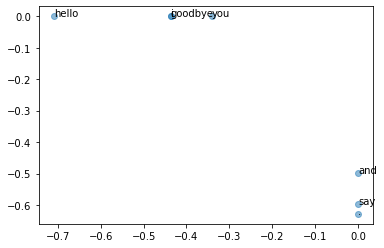

In [35]:
# 그래프로 표현
import matplotlib.pyplot as plt

for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
    
plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

### PTB 데이터셋

In [38]:
import sys
sys.path.append('..')
from dataset import ptb

In [39]:
corpus, word_to_id, id_to_word = ptb.load_data('train') # 인수로 훈련용(train), 테스트용(test), 검증용(valid) 가능

print('말뭉치 크기:', len(corpus))
print('corpus[:30]:', corpus[:30]) # 단어 ID 목록
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

Done
말뭉치 크기: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


In [40]:
from dataset import ptb


window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('동시발생 수 계산 ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('PPMI 계산 ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')
try:
    # truncated SVD (빠른 ver.)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
except ImportError:
    # SVD (느린 ver.)
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


동시발생 수 계산 ...
PPMI 계산 ...


C:\Users\JUNGSU~1\AppData\Local\Temp/ipykernel_24696/3617057779.py:10: RuntimeWarning: overflow encountered in long_scalars
  pmi = np.log2(C[i,j] * N / (S[j]*S[i]) + eps)
C:\Users\JUNGSU~1\AppData\Local\Temp/ipykernel_24696/3617057779.py:10: RuntimeWarning: invalid value encountered in log2
  pmi = np.log2(C[i,j] * N / (S[j]*S[i]) + eps)


1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 완료
99.0% 완료
calculating SVD ...

[query] you
 i: 0.6569777727127075
 we: 0.6029386520385742
 anybody: 0.5620438456535339
 do: 0.53